In [1]:
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from util import *
import tensorflow as tf
from sklearn.metrics import mean_squared_error, f1_score, average_precision_score, log_loss

%matplotlib inline

2022-10-31 22:47:16.501062: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-31 22:47:16.501089: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def shap_difference(org_phi, mod_phi, type='c-index'):
    assert np.shape(org_phi) == np.shape(mod_phi)
    org_phi = np.array(org_phi).flatten()
    mod_phi = np.array(mod_phi).flatten()
    phi_len = len(org_phi)
    c = 0
    for i in range(phi_len):
        for j in range(i + 1, phi_len):
            if (org_phi[i] > org_phi[j] and mod_phi[i] > mod_phi[j]) or\
            (org_phi[i] < org_phi[j] and mod_phi[i] < mod_phi[j]) or\
            (org_phi[i] == org_phi[j] and mod_phi[i] == mod_phi[j]):
                c = c + 1
    c = 2*c/(phi_len**2 - phi_len)
    return c

In [3]:
org_ts_phi = []
for test_id in range(10):
        # Read already saved result
        save_name = 'track_exp{}_test{}_cv{}'.format(1, test_id, 1)
        with open(OUTPUT_PATH + save_name, 'rb') as f:
            obj = pickle.load(f)
        org_ts_phi.append(obj['ts_phi'])

In [3]:
def xai_results_reader(exp_min = 1, exp_max = 18, num_test=10, loss_fun='mse', eval_type='all', memory_bool=False,
                       percentile = 80, seq_len = 10, model_type='track', cv=0, c_index_bool=False):
    memory = []
    runtime = []
    c_index = []
    prtb = []
    sqnc_eval = []
    if loss_fun == 'BinaryCrossentropy':
        loss = lambda x,y: log_loss(x,y,labels=[0,1])
    elif loss_fun == 'mse':
        loss = mean_squared_error
    elif loss_fun == 'f1':
        loss = lambda x, y: f1_score(x, np.round(y))
    elif loss_fun == 'ap':
        loss = average_precision_score
    elif loss_fun == 'auc':
        loss = roc_auc_score
    
    for exp_id in range(exp_min, exp_max + 1):
        temp_memory = []
        temp_runtime = []
        temp_c_index = []
        temp_prtb = []
        temp_sqnc_eval = []
        predicted_y = []
        true_y = []
        for test_id in range(num_test):
            # Read already saved result
            save_name = model_type + '_exp{}_test{}_cv{}'.format(exp_id, test_id, cv)
            with open(OUTPUT_PATH + save_name, 'rb') as f:
                obj = pickle.load(f)
            if memory_bool: temp_memory.append(obj['memory'])
            temp_runtime.append(obj['total_time'])
            temp_prtb.append(obj['prtb_eval_{}'.format(eval_type)][percentile-10])
            temp_sqnc_eval.append(obj['seq_eval_{}'.format(eval_type)][percentile-10,seq_len-1])
            predicted_y.append(obj['predicted_y'])
            true_y.append(obj['true_y'])
            if c_index_bool: temp_c_index.append(shap_difference(org_ts_phi[test_id], obj['ts_phi']))
        if memory_bool: memory.append(np.mean(temp_memory)/1024)
        runtime.append(np.mean(temp_runtime))
        if c_index_bool: c_index.append(np.mean(temp_c_index))
        predicted_y = np.squeeze(predicted_y)
        true_y = np.squeeze(true_y)
        base_loss = loss(true_y, predicted_y)
        prtb.append(loss(true_y, temp_prtb)/base_loss)
        sqnc_eval.append(loss(true_y, temp_sqnc_eval)/base_loss)
    exp_setting = pd.read_csv(DATA_PATH + 'Shap Experiments/experiment features.csv')
    exp_setting = exp_setting[(exp_setting.id <=exp_max)&(exp_setting.id >=exp_min)]
    return memory, runtime, c_index, prtb, sqnc_eval, exp_setting

# Stationary Time Window

In [53]:
memory, runtime, c_index, prtb, sqnc_eval, exp_setting = xai_results_reader(exp_min=1, exp_max=18, c_index_bool=False, model_type='track')
window_len_list = exp_setting.window_len.to_numpy()

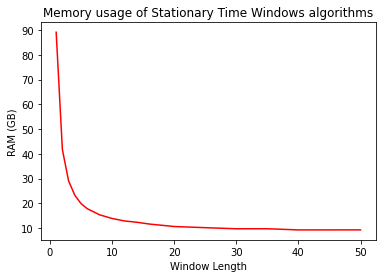

In [54]:
plt.plot(window_len_list, memory, '-r')
# plt.plot(exp_setting, memory_2, '-b')
plt.xlabel('Window Length')
plt.ylabel('RAM (GB)')
plt.title('Memory usage of Stationary Time Windows algorithms')
plt.show()

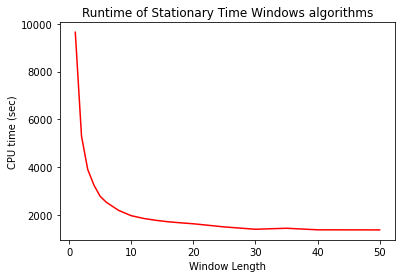

In [55]:
plt.plot(window_len_list, runtime, '-r')
# plt.plot(exp_setting, runtime_2, '-b')
plt.xlabel('Window Length')
plt.ylabel('CPU time (sec)')
plt.title('Runtime of Stationary Time Windows algorithms')
plt.show()

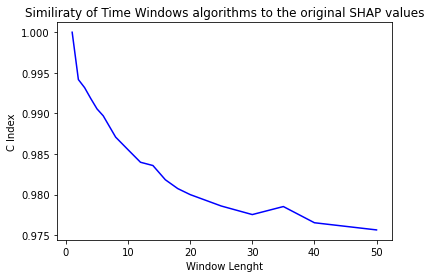

In [52]:
plt.plot(window_len_list, c_index, '-b')
plt.xlabel('Window Lenght')
plt.ylabel('C Index')
plt.title('Similiraty of Time Windows algorithms to the original SHAP values')
plt.show()

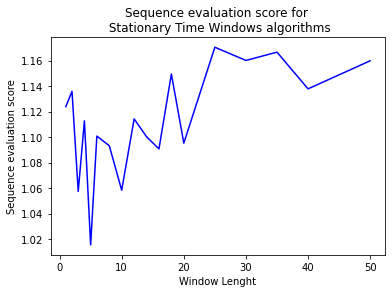

In [53]:
# plt.plot(np.arange(len(memory)), prtb, '-r')
plt.plot(window_len_list, sqnc_eval, '-b')
plt.xlabel('Window Lenght')
plt.ylabel('Sequence evaluation score')
plt.title('Sequence evaluation score for \n Stationary Time Windows algorithms')
plt.show()

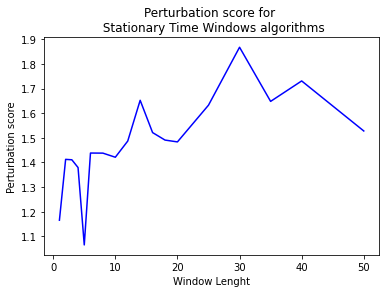

In [54]:
plt.plot(window_len_list, prtb, '-b')
plt.xlabel('Window Lenght')
plt.ylabel('Perturbation score')
plt.title('Perturbation score for \n Stationary Time Windows algorithms')
plt.show()

# Sliding Time Window

In [26]:
memory, runtime, c_index, prtb, sqnc_eval, exp_setting = xai_results_reader(exp_min=19, exp_max=63, c_index_bool=True, model_type='track')

In [27]:
exp_setting['memory']= memory
exp_setting['prtb']= prtb
exp_setting['sqnc_eval']= sqnc_eval
exp_setting['runtime']= runtime
exp_setting['c_index']= c_index
exp_memory = exp_setting.pivot(index='window_len', columns='stride', values='memory')
exp_sqnc_eval = exp_setting.pivot(index='window_len', columns='stride', values='sqnc_eval')
exp_runtime = exp_setting.pivot(index='window_len', columns='stride', values='runtime')
exp_prtb = exp_setting.pivot(index='window_len', columns='stride', values='prtb')
exp_c_index = exp_setting.pivot(index='window_len', columns='stride', values='c_index')

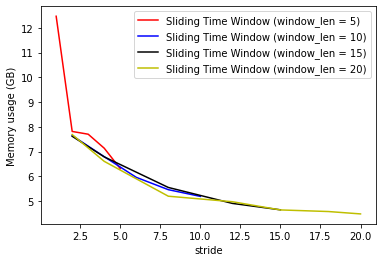

In [58]:
mem_5 = exp_memory[exp_memory.index==5].dropna(axis=1).to_numpy().squeeze()
stride_5 = exp_memory[exp_memory.index==5].dropna(axis=1).columns.tolist()

mem_10 = exp_memory[exp_memory.index==10].dropna(axis=1).to_numpy().squeeze()
stride_10 = exp_memory[exp_memory.index==10].dropna(axis=1).columns.tolist()

mem_15 = exp_memory[exp_memory.index==15].dropna(axis=1).to_numpy().squeeze()
stride_15 = exp_memory[exp_memory.index==15].dropna(axis=1).columns.tolist()

mem_20 = exp_memory[exp_memory.index==20].dropna(axis=1).to_numpy().squeeze()
stride_20 = exp_memory[exp_memory.index==20].dropna(axis=1).columns.tolist()

plt.plot(stride_5, mem_5, '-r', label='Sliding Time Window (window_len = 5)')
plt.plot(stride_10, mem_10, '-b', label='Sliding Time Window (window_len = 10)')
plt.plot(stride_15, mem_15, '-k', label='Sliding Time Window (window_len = 15)')
plt.plot(stride_20, mem_20, '-y', label='Sliding Time Window (window_len = 20)')

plt.legend()
plt.xlabel('stride')
plt.ylabel('Memory usage (GB)')
plt.show()

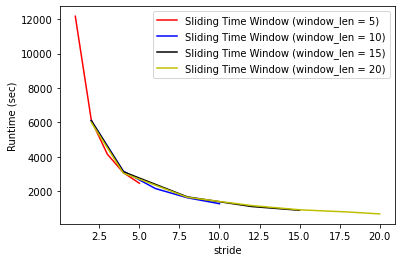

In [59]:
mem_5 = exp_runtime[exp_memory.index==5].dropna(axis=1).to_numpy().squeeze()
stride_5 = exp_runtime[exp_memory.index==5].dropna(axis=1).columns.tolist()

mem_10 = exp_runtime[exp_memory.index==10].dropna(axis=1).to_numpy().squeeze()
stride_10 = exp_runtime[exp_memory.index==10].dropna(axis=1).columns.tolist()

mem_15 = exp_runtime[exp_memory.index==15].dropna(axis=1).to_numpy().squeeze()
stride_15 = exp_runtime[exp_memory.index==15].dropna(axis=1).columns.tolist()

mem_20 = exp_runtime[exp_memory.index==20].dropna(axis=1).to_numpy().squeeze()
stride_20 = exp_runtime[exp_memory.index==20].dropna(axis=1).columns.tolist()

plt.plot(stride_5, mem_5, '-r', label='Sliding Time Window (window_len = 5)')
plt.plot(stride_10, mem_10, '-b', label='Sliding Time Window (window_len = 10)')
plt.plot(stride_15, mem_15, '-k', label='Sliding Time Window (window_len = 15)')
plt.plot(stride_20, mem_20, '-y', label='Sliding Time Window (window_len = 20)')

plt.legend()
plt.xlabel('stride')
plt.ylabel('Runtime (sec)')
plt.show()

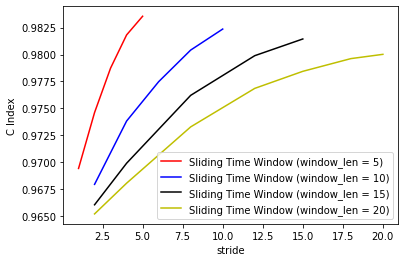

In [60]:
mem_5 = exp_c_index[exp_memory.index==5].dropna(axis=1).to_numpy().squeeze()
stride_5 = exp_c_index[exp_memory.index==5].dropna(axis=1).columns.tolist()

mem_10 = exp_c_index[exp_memory.index==10].dropna(axis=1).to_numpy().squeeze()
stride_10 = exp_c_index[exp_memory.index==10].dropna(axis=1).columns.tolist()

mem_15 = exp_c_index[exp_memory.index==15].dropna(axis=1).to_numpy().squeeze()
stride_15 = exp_c_index[exp_memory.index==15].dropna(axis=1).columns.tolist()

mem_20 = exp_c_index[exp_memory.index==20].dropna(axis=1).to_numpy().squeeze()
stride_20 = exp_c_index[exp_memory.index==20].dropna(axis=1).columns.tolist()

plt.plot(stride_5, mem_5, '-r', label='Sliding Time Window (window_len = 5)')
plt.plot(stride_10, mem_10, '-b', label='Sliding Time Window (window_len = 10)')
plt.plot(stride_15, mem_15, '-k', label='Sliding Time Window (window_len = 15)')
plt.plot(stride_20, mem_20, '-y', label='Sliding Time Window (window_len = 20)')

plt.legend()
plt.xlabel('stride')
plt.ylabel('C Index')
plt.show()

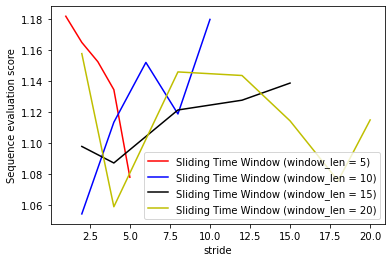

In [61]:
mem_5 = exp_sqnc_eval[exp_memory.index==5].dropna(axis=1).to_numpy().squeeze()
stride_5 = exp_sqnc_eval[exp_memory.index==5].dropna(axis=1).columns.tolist()

mem_10 = exp_sqnc_eval[exp_memory.index==10].dropna(axis=1).to_numpy().squeeze()
stride_10 = exp_sqnc_eval[exp_memory.index==10].dropna(axis=1).columns.tolist()

mem_15 = exp_sqnc_eval[exp_memory.index==15].dropna(axis=1).to_numpy().squeeze()
stride_15 = exp_sqnc_eval[exp_memory.index==15].dropna(axis=1).columns.tolist()

mem_20 = exp_sqnc_eval[exp_memory.index==20].dropna(axis=1).to_numpy().squeeze()
stride_20 = exp_sqnc_eval[exp_memory.index==20].dropna(axis=1).columns.tolist()

plt.plot(stride_5, mem_5, '-r', label='Sliding Time Window (window_len = 5)')
plt.plot(stride_10, mem_10, '-b', label='Sliding Time Window (window_len = 10)')
plt.plot(stride_15, mem_15, '-k', label='Sliding Time Window (window_len = 15)')
plt.plot(stride_20, mem_20, '-y', label='Sliding Time Window (window_len = 20)')

plt.legend()
plt.xlabel('stride')
plt.ylabel('Sequence evaluation score')
plt.show()

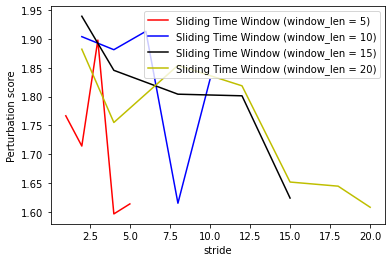

In [62]:
mem_5 = exp_prtb[exp_memory.index==5].dropna(axis=1).to_numpy().squeeze()
stride_5 = exp_prtb[exp_memory.index==5].dropna(axis=1).columns.tolist()

mem_10 = exp_prtb[exp_memory.index==10].dropna(axis=1).to_numpy().squeeze()
stride_10 = exp_prtb[exp_memory.index==10].dropna(axis=1).columns.tolist()

mem_15 = exp_prtb[exp_memory.index==15].dropna(axis=1).to_numpy().squeeze()
stride_15 = exp_prtb[exp_memory.index==15].dropna(axis=1).columns.tolist()

mem_20 = exp_prtb[exp_memory.index==20].dropna(axis=1).to_numpy().squeeze()
stride_20 = exp_prtb[exp_memory.index==20].dropna(axis=1).columns.tolist()

plt.plot(stride_5, mem_5, '-r', label='Sliding Time Window (window_len = 5)')
plt.plot(stride_10, mem_10, '-b', label='Sliding Time Window (window_len = 10)')
plt.plot(stride_15, mem_15, '-k', label='Sliding Time Window (window_len = 15)')
plt.plot(stride_20, mem_20, '-y', label='Sliding Time Window (window_len = 20)')

plt.legend()
plt.xlabel('stride')
plt.ylabel('Perturbation score')
plt.show()

# Binary Time Window

In [28]:
memory, runtime, c_index, prtb, sqnc_eval, exp_setting = xai_results_reader(exp_min=64, exp_max=103, c_index_bool=False, model_type='track')

In [29]:
exp_setting['memory']= memory
exp_setting['runtime']= runtime
# exp_setting['c_index']= c_index
exp_setting['prtb']= prtb
exp_setting['sqnc_eval']= sqnc_eval
exp_memory = exp_setting.pivot(index='delta', columns='n_w', values='memory')
exp_runtime = exp_setting.pivot(index='delta', columns='n_w', values='runtime')
# exp_c_index = exp_setting.pivot(index='delta', columns='n_w', values='c_index')
exp_prtb = exp_setting.pivot(index='delta', columns='n_w', values='prtb')
exp_sqnc_eval = exp_setting.pivot(index='delta', columns='n_w', values='sqnc_eval')

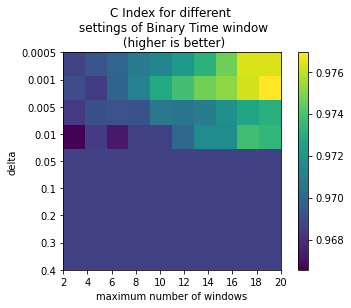

In [65]:
fig, ax = plt.subplots(1,1)

img = ax.imshow(exp_c_index.to_numpy(), extent=[-1,1,-1,1])

y_label_list = exp_setting.delta.unique()
x_label_list = exp_setting.n_w.unique()

ax.set_xticks(np.linspace(start=-1, stop=1, num=len(x_label_list)))
ax.set_yticks(np.linspace(start=1, stop=-1, num=len(y_label_list)))

ax.set_xticklabels(x_label_list.astype(int))
ax.set_yticklabels(y_label_list)

ax.set_xlabel('maximum number of windows')
ax.set_ylabel('delta')
ax.set_title('C Index for different \n settings of Binary Time window\
\n (higher is better)')

fig.colorbar(img)

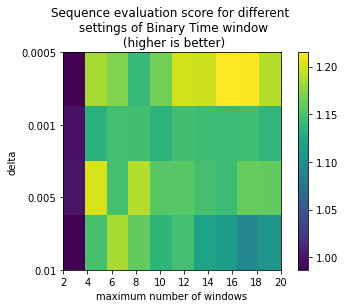

In [30]:
fig, ax = plt.subplots(1,1)

img = ax.imshow(exp_sqnc_eval.to_numpy(), extent=[-1,1,-1,1])

y_label_list = exp_setting.delta.unique()
x_label_list = exp_setting.n_w.unique()

ax.set_xticks(np.linspace(start=-1, stop=1, num=len(x_label_list)))
ax.set_yticks(np.linspace(start=1, stop=-1, num=len(y_label_list)))

ax.set_xticklabels(x_label_list.astype(int))
ax.set_yticklabels(y_label_list)

ax.set_xlabel('maximum number of windows')
ax.set_ylabel('delta')
ax.set_title('Sequence evaluation score for different \n settings of Binary Time window\
\n (higher is better)')

fig.colorbar(img)

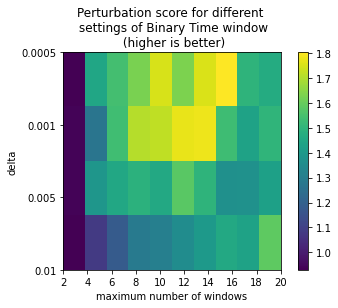

In [31]:
fig, ax = plt.subplots(1,1)

img = ax.imshow(exp_prtb.to_numpy(), extent=[-1,1,-1,1])

y_label_list = exp_setting.delta.unique()
x_label_list = exp_setting.n_w.unique()

ax.set_xticks(np.linspace(start=-1, stop=1, num=len(x_label_list)))
ax.set_yticks(np.linspace(start=1, stop=-1, num=len(y_label_list)))

ax.set_xticklabels(x_label_list.astype(int))
ax.set_yticklabels(y_label_list)

ax.set_xlabel('maximum number of windows')
ax.set_ylabel('delta')
ax.set_title('Perturbation score for different \n settings of Binary Time window\
\n (higher is better)')

fig.colorbar(img)
fig.show()

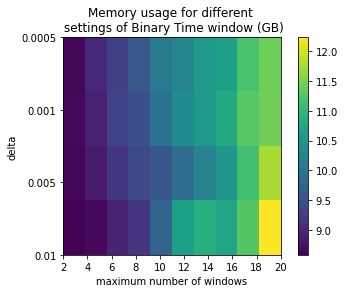

In [32]:
fig, ax = plt.subplots(1,1)

img = ax.imshow(exp_memory.to_numpy(), extent=[-1,1,-1,1])

y_label_list = exp_setting.delta.unique()
x_label_list = exp_setting.n_w.unique()

ax.set_xticks(np.linspace(start=-1, stop=1, num=len(x_label_list)))
ax.set_yticks(np.linspace(start=1, stop=-1, num=len(y_label_list)))

ax.set_xticklabels(x_label_list.astype(int))
ax.set_yticklabels(y_label_list)

ax.set_xlabel('maximum number of windows')
ax.set_ylabel('delta')
ax.set_title('Memory usage for different \n settings of Binary Time window (GB)')

fig.colorbar(img)

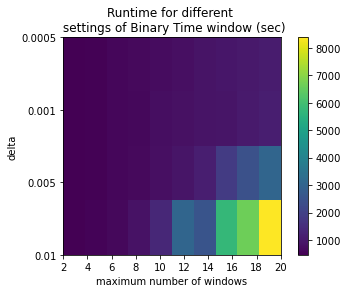

In [34]:
fig, ax = plt.subplots(1,1)
# exp_runtime.iloc[6, 4] = 17
# exp_runtime.iloc[6, 5] = 17
# exp_runtime.iloc[6, 6] = 17
img = ax.imshow(exp_runtime.to_numpy(), extent=[-1,1,-1,1])

y_label_list = exp_setting.delta.unique()
x_label_list = exp_setting.n_w.unique()

ax.set_xticks(np.linspace(start=-1, stop=1, num=len(x_label_list)))
ax.set_yticks(np.linspace(start=1, stop=-1, num=len(y_label_list)))

ax.set_xticklabels(x_label_list.astype(int))
ax.set_yticklabels(y_label_list)

ax.set_xlabel('maximum number of windows')
ax.set_ylabel('delta')
ax.set_title('Runtime for different \n settings of Binary Time window (sec)')

fig.colorbar(img)

In [35]:
exp_runtime

n_w,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0
delta,,,,,,,,,,
0.0005,466.396375,506.532792,598.377562,649.718967,735.405644,783.959266,888.745873,931.338106,992.929217,1055.759639
0.0010,469.068873,512.268651,600.705291,640.083125,745.957966,824.443434,886.769953,920.497504,1024.575438,1124.162502
0.0050,458.188080,507.676100,595.476547,662.157052,784.930706,899.054647,1111.662653,1840.634945,2439.189796,3030.291633
0.0100,459.000014,520.274401,625.459753,832.928032,1348.218548,3054.762718,2522.487728,5724.375396,6647.375297,8385.385035


Text(0, 0.5, 'Perturbation score')

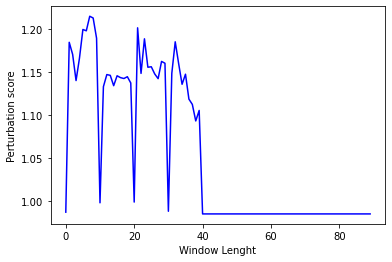

In [70]:
# plt.plot(np.arange(len(memory)), prtb, '-r')
plt.plot(np.arange(len(memory)), sqnc_eval, '-b')
plt.xlabel('Window Lenght')
plt.ylabel('Perturbation score')

# TimeSHAP

In [ ]:
memory, runtime, c_index, prtb, sqnc_eval, exp_setting = xai_results_reader(exp_min=154, exp_max=165, c_index_bool=False, model_type='track')
tol_list = exp_setting.tol.to_numpy()

ValueError: x and y must have same first dimension, but have shapes (12,) and (0,)

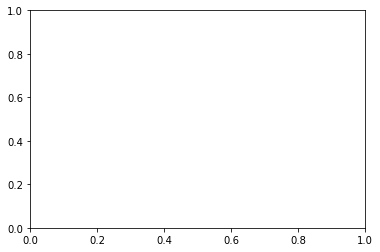

In [5]:
plt.plot(tol_list, memory, '-r')
# plt.plot(exp_setting, memory_2, '-b')
plt.xlabel('Window Lenght')
plt.ylabel('RAM (GB)')
plt.title('Memory usage of Stationary Time Windows algorithms')
plt.show()

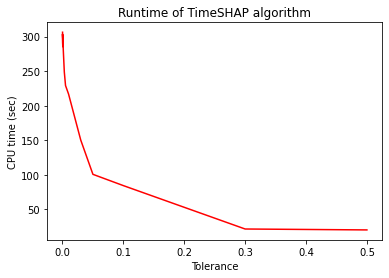

In [8]:
plt.plot(tol_list, runtime, '-r')
# plt.plot(exp_setting, runtime_2, '-b')
plt.xlabel('Tolerance')
plt.ylabel('CPU time (sec)')
plt.title('Runtime of TimeSHAP algorithm')
plt.show()

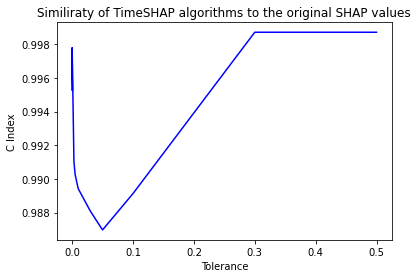

In [9]:
plt.plot(tol_list, c_index, '-b')
plt.xlabel('Tolerance')
plt.ylabel('C Index')
plt.title('Similiraty of TimeSHAP algorithms to the original SHAP values')
plt.show()

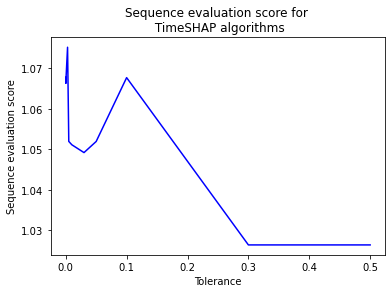

In [10]:
# plt.plot(np.arange(len(memory)), prtb, '-r')
plt.plot(tol_list, sqnc_eval, '-b')
plt.xlabel('Tolerance')
plt.ylabel('Sequence evaluation score')
plt.title('Sequence evaluation score for \n TimeSHAP algorithms')
plt.show()

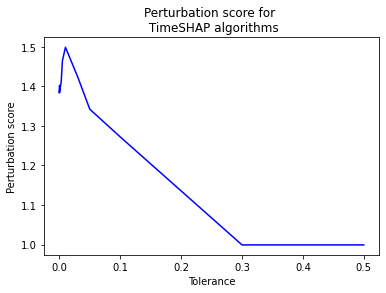

In [11]:
plt.plot(tol_list, prtb, '-b')
plt.xlabel('Tolerance')
plt.ylabel('Perturbation score')
plt.title('Perturbation score for \n TimeSHAP algorithms')
plt.show()

# Comparison of methods

In [4]:
window_len_1 = 20
window_len_2 = 15
stride = 8
delta = 0.010
n_w = 20
tol = 0.050
# -----------------------
min_p = 60
max_p = 90
min_len = 10
max_len = 30
eval_type = 'all'
loss_fun = 'BinaryCrossentropy'
# ------------------------

exp_ids = [0]*5
exp_ids[0] = 1
exp_setting = pd.read_csv(DATA_PATH + 'Shap Experiments/experiment features.csv')
exp_ids[1] = exp_setting[(exp_setting.window_len==window_len_1) & (exp_setting.method=='STW')].id.to_numpy()[0]
exp_ids[2] = exp_setting[(exp_setting.window_len==window_len_2) & (exp_setting.stride==stride)
                       & (exp_setting.method=='SLTW')].id.to_numpy()[0]
exp_ids[3] = exp_setting[(exp_setting.delta==delta) & (exp_setting.n_w==n_w) 
                       & (exp_setting.method=='BTW')].id.to_numpy()[0]
exp_ids[4] = exp_setting[(exp_setting.tol==tol) & (exp_setting.method=='TIMESHAP')].id.to_numpy()[0]

sqnc_evals = np.zeros((5, max_p - min_p, max_len - min_len))
prtb = np.zeros((5, max_p - min_p))

for p in range(min_p, max_p):
    for seq_len in range(min_len, max_len):
        for i in range(5):
            exp_id = exp_ids[i]
            _, _, _, prtb_temp, sqnc_eval_temp, _ = xai_results_reader(exp_min=exp_id, exp_max=exp_id, eval_type=eval_type,
                                                                       percentile=p, seq_len=seq_len, cv=1, loss_fun=loss_fun,
                                                                       num_test=50)
            prtb[i, p-min_p] = prtb_temp[0]
            sqnc_evals[i, p-min_p, seq_len-min_len] = sqnc_eval_temp[0]
            

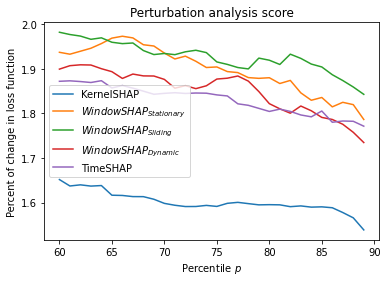

In [5]:
labels = ['KernelSHAP',r'$WindowSHAP_{Stationary}$',r'$WindowSHAP_{Sliding}$',r'$WindowSHAP_{Dynamic}$','TimeSHAP']
plt.plot(np.arange(min_p, max_p), prtb.T, label=labels)
plt.xlabel(r'Percentile $p$')
plt.ylabel('Percent of change in loss function')
plt.title('Perturbation analysis score')
plt.legend()
plt.show()

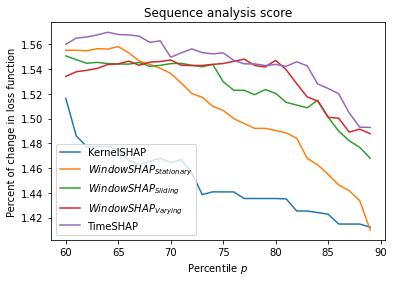

In [8]:
plt.plot(np.arange(min_p, max_p), sqnc_evals[:,:,3].T, label=labels)
plt.xlabel(r'Percentile $p$')
plt.ylabel('Percent of change in loss function')
plt.title('Sequence analysis score')
plt.legend()
plt.show()